In [ ]:
#Experiments and Plots with LRP

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.models.NCA import MaxNCA
from src.agents.Agent import Agent
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [180]:
class BasicNCA(nn.Module):
    def __init__(self, channel_n=16, fire_rate=0.5, device="cpu", hidden_size=128, input_channels=3, init_method="standard"):
        super(BasicNCA, self).__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.channel_n = channel_n
        self.input_channels = input_channels
        self.p0 = nn.Conv2d(channel_n, channel_n, kernel_size=3, stride=1, padding=1, groups = channel_n, padding_mode="reflect")
        self.p1 = nn.Conv2d(channel_n, channel_n, kernel_size=3, stride=1, padding=1, groups = channel_n, padding_mode="reflect")
        self.fc0 = nn.Linear(channel_n*3, hidden_size)
        self.fc1 = nn.Linear(hidden_size, channel_n, bias=False)
        self.fc2 = nn.Linear(channel_n,128)
        self.fc3 = nn.Linear(128,11)
        self.fire_rate = fire_rate
        self.to(self.device)

    def perceive(self, x):
        z1 = self.p0(x)
        z2 = self.p1(x)
        y = torch.cat((x,z1,z2),1)
        return y

    def update(self, x_in, fire_rate):
        x = x_in.transpose(1,3)
        dx = self.perceive(x)
        dx = dx.transpose(1,3)
        dx = self.fc0(dx)
        dx = F.relu(dx)
        dx = self.fc1(dx)

        if fire_rate is None:
            fire_rate=self.fire_rate
        stochastic = torch.rand([dx.size(0),dx.size(1),dx.size(2),1])>fire_rate
        stochastic = stochastic.float().to(self.device)
        dx = dx * stochastic
        x = x+dx.transpose(1,3)
        x = x.transpose(1,3)
        return x

    def forward(self, x, steps=32, fire_rate=0.5):
        for step in range(steps):
            x2 = self.update(x, fire_rate).clone()
            x = torch.concat((x[...,:self.input_channels], x2[...,self.input_channels:]), 3)
        max=F.adaptive_max_pool2d(x.permute(0, 3, 1, 2), (1, 1))
        max = max.view(max.size(0), -1)
        #out = self.fc2(x.mean([1,2]))
        out=self.fc2(max)
        out = F.relu(out)
        out =self.fc3(out)
        return out,x

In [2]:
#Define split model for lrp on classifier

class NCA_max(nn.Module):
    def __init__(self, channel_n=16, fire_rate=0.5, device="cpu", hidden_size=128, input_channels=3, init_method="standard"):
        super(NCA_max, self).__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.channel_n = channel_n
        self.input_channels = input_channels
        self.p0 = nn.Conv2d(channel_n, channel_n, kernel_size=3, stride=1, padding=1, groups = channel_n, padding_mode="reflect")
        self.p1 = nn.Conv2d(channel_n, channel_n, kernel_size=3, stride=1, padding=1, groups = channel_n, padding_mode="reflect")
        self.fc0 = nn.Linear(channel_n*3, hidden_size)
        self.fc1 = nn.Linear(hidden_size, channel_n, bias=False)
        self.fire_rate = fire_rate
        self.to(self.device)

    def perceive(self, x):
        z1 = self.p0(x)
        z2 = self.p1(x)
        y = torch.cat((x,z1,z2),1)
        return y

    def update(self, x_in, fire_rate):
        x = x_in.transpose(1,3)
        dx = self.perceive(x)
        dx = dx.transpose(1,3)
        dx = self.fc0(dx)
        dx = F.relu(dx)
        dx = self.fc1(dx)

        if fire_rate is None:
            fire_rate=self.fire_rate
        stochastic = torch.rand([dx.size(0),dx.size(1),dx.size(2),1])>fire_rate
        stochastic = stochastic.float().to(self.device)
        dx = dx * stochastic
        x = x+dx.transpose(1,3)
        x = x.transpose(1,3)
        return x

    def forward(self, x, steps=32, fire_rate=0.5):
        for step in range(steps):
            x2 = self.update(x, fire_rate).clone()
            x = torch.concat((x[...,:self.input_channels], x2[...,self.input_channels:]), 3)
        max=F.adaptive_max_pool2d(x.permute(0, 3, 1, 2), (1, 1))
        out = max.view(max.size(0), -1)
        return out#,x

class Classifier(nn.Module):
    def __init__(self,channel_n=16):
        super(Classifier, self).__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.channel_n=channel_n
        self.fc2 = nn.Linear(channel_n,128)
        self.fc3 = nn.Linear(128,13)
        self.to(self.device)

    def forward(self, x):
        out = self.fc2(x)
        out = F.relu(out)
        out =self.fc3(out)
        return out#,x

In [3]:
#get model, load weights, split 
#MaxNCA_trained_on_AML: 64 channels, 64 steps, 128 hidden, 128 last layer
#trained_on_AML: 11 classes
channels=128
model=MaxNCA(channels,128)
agent=Agent(model,64,channels,1)
model.load_state_dict(torch.load("models\\modelMax128chan64step_trained_on_AML",map_location=torch.device('cpu')))
model.eval()
model1=NCA_max(channels,128)
model2=Classifier(channels)

original_state_dict = model.state_dict()
model1_dict = model1.state_dict()
model2_dict = model2.state_dict()

model1_dict.update({k: v for k, v in original_state_dict.items() if 'p0' in k or 'p1' in k or 'fc0' in k or 'fc1' in k})
model2_dict.update({k: v for k, v in original_state_dict.items() if 'fc2' in k or 'fc3' in k})

# Load the modified state_dict into the new model
model1.load_state_dict(model1_dict)
model2.load_state_dict(model2_dict)

<All keys matched successfully>

In [ ]:
imgs_path=["test_samples\\EBO_0001.tiff",
                "test_samples\\EOS_0001.tiff",
                "test_samples\\KSC_0001.tiff",
                "test_samples\\LYA_0001.tiff",
                "test_samples\\LYT_0001.tiff",
                "test_samples\\MMZ_0001.tiff",
                "test_samples\\MOB_0001.tiff",
                "test_samples\\MON_0001.tiff",
                "test_samples\\MYB_0001.tiff",
                "test_samples\\MYO_0001.tiff",
                "test_samples\\NGB_0001.tiff",
                "test_samples\\NGS_0001.tiff",
                "test_samples\\PMO_0001.tiff",
                "test_samples\\BAS_0001.tiff"]
def get_sample(i=1,imgs_path=[]):
    imgs_path=imgs_path

    norm = v2.Compose([v2.ToTensor(), v2.Normalize(mean=[0.82069695, 0.7281261, 0.836143],std=[0.16157213, 0.2490039, 0.09052657])])
    img = Image.open(imgs_path[i])
    img = img.resize((64,64))
    img=np.array(img)[:,:,0:3]
    img = norm(img).permute(1,2,0)
    return img[None,:,:,:]

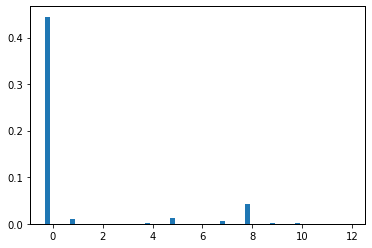

In [9]:
import zennit.composites as z
from zennit.attribution import Gradient
import numpy as np
import matplotlib as mpl
composite = z.EpsilonPlus()

img=get_sample(13,imgs_path=imgs_path)
x=agent.make_seed(img)
input = model1(x)
max=[]
min=[]
with Gradient(model2, composite) as attributor:
    output, relevance = attributor(input, torch.eye(13)[[4]])
#print(np.array(min))
#print(np.array(max))
mpl.rcParams['axes.linewidth'] = 1
size=0.2
X_axis = np.arange(13) 
plt.bar(X_axis -size,F.sigmoid(output[0]).detach().numpy(),size)
#plt.bar(X_axis ,min,size)
#plt.bar(X_axis +size,max,size)
#relevance=F.tanh(relevance).numpy()
relevance=(relevance-relevance.min())/(relevance.max()-relevance.min())
relevance=2*relevance-1

relevance=relevance.numpy()

In [431]:
relevance=(relevance-relevance.min())/(relevance.max()-relevance.min())
print(r_s)

[[0.5610774  0.5641157  0.57532215 0.41956425 0.27259594 0.7569393
  0.8359932  0.9506592  0.3946841  0.4234633  0.48703334 0.4407886
  0.461497   0.59533507 0.6344752  0.8463232  0.89292127 0.45325035
  0.33427066 0.50573695 0.53604406 0.73891175 0.55623686 0.3606774
  0.5597471  0.8967409  0.42315552 0.38364393 0.4843522  0.
  0.83998996 0.8543889  0.47234482 0.21777357 0.61253995 0.40239927
  0.7753738  0.6805572  0.48154536 0.35424364 0.44555852 0.4739509
  0.39495516 0.44418547 0.19955687 0.5160798  0.597745   0.31897745
  0.0611839  0.3196781  0.48851094 0.5846715  0.3690866  0.02773491
  0.69843036 0.49287334 0.18707925 0.29261455 0.32429567 0.28253436
  0.1828291  0.5425285  0.6862398  0.63567626 0.40948233 0.5382917
  0.66931605 0.78221095 0.54088455 0.6873768  0.43824458 0.51660895
  0.72787124 0.37564436 0.57721883 0.55687046 0.3982817  0.71824783
  0.5189265  0.37481424 0.49694666 0.557014   0.49872434 0.54901284
  0.6618535  0.4065041  0.44195792 0.5224648  0.70715123 0.79

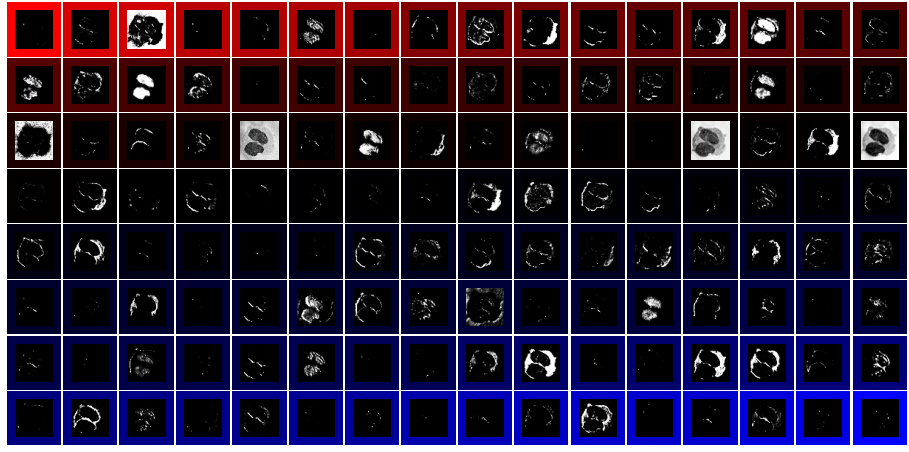

In [8]:
#Plot of all channel activations

import numpy as np
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 8
sample=img2[None,:,:,:]

idx=np.argsort(relevance[0])
idx=np.flip(idx)
rel=[relevance[0,i] for i in idx]

height=8
width=16

plt.figure("visualise", (width,height))
out,feat_map=model(agent.make_seed(sample), steps=64,fire_rate=0.5)
feature_map=feat_map.detach()
sig=torch.nn.Sigmoid()
feature_map_sig=sig(feature_map-5) #sigmoid is applied for visualization, changing this function controls how much of the feature is visible in the plot
feature_map=torch.cat((feature_map[:,:,:,:3],feature_map_sig[:,:,:,3:]),axis=3).cpu()
for i in range(height):
    for j in range(width):
        channel=width*i+j
        ax= plt.subplot(height,width,channel+1)
        r=relevance[0,idx[channel]]
        if r>0:
            ax.spines['bottom'].set_color((r,0,0))
            ax.spines['top'].set_color((r,0,0))
            ax.spines['left'].set_color((r,0,0))
            ax.spines['right'].set_color((r,0,0))
        else:
            ax.spines['bottom'].set_color((0,0,-r))
            ax.spines['top'].set_color((0,0,-r))
            ax.spines['left'].set_color((0,0,-r))
            ax.spines['right'].set_color((0,0,-r))
        plt.xticks([])
        plt.yticks([])
        plt.gray()
        plt.imshow(feature_map[0,:,:,idx[channel]])

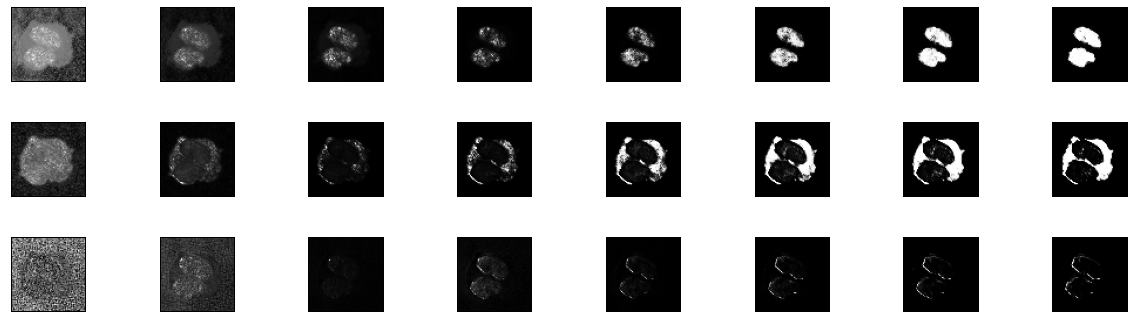

In [473]:
#Plot of three feature over time

channels=[108,50,80]
nplots=8
mpl.rcParams['axes.linewidth'] = 1
plt.figure("visualise", (20,6))
for j in range(3):
    channel=channels[j]
    for i in range(nplots):
        steps=8*(1+i)
        out,feat_map=model(agent.make_seed(sample), steps=steps,fire_rate=0.5)
        feature_map=feat_map.detach()
        sig=torch.nn.Sigmoid()
        feature_map_sig=sig(feature_map-5)
        feature_map=torch.cat((feature_map[:,:,:,:3],feature_map_sig[:,:,:,3:]),axis=3).cpu()

        plt.subplot(3,nplots,j*nplots+i+1)
        plt.subplots_adjust(wspace=1)
        plt.xticks([])
        plt.yticks([])
        plt.gray()
        plt.imshow(feature_map[0,:,:,idx[channel]])
plt.savefig("channel_activations.svg")

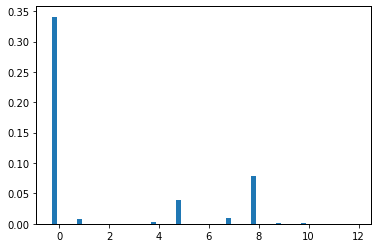

In [8]:
import zennit.composites as z
from zennit.attribution import Gradient
import numpy as np
import matplotlib as mpl
composite = z.EpsilonPlus()

img=get_sample(13,imgs_path=imgs_path)
x=agent.make_seed(img)
#plt.imshow(img[0])
input = model1(x)
with Gradient(model2, composite) as attributor:
    output, relevance = attributor(input, torch.eye(13)[[4]])
mpl.rcParams['axes.linewidth'] = 1
size=0.2
X_axis = np.arange(13) 
plt.bar(X_axis -size,F.sigmoid(output[0]).detach().numpy(),size)
relevance=(relevance-relevance.min())/(relevance.max()-relevance.min())
relevance=2*relevance-1

relevance=relevance.numpy()

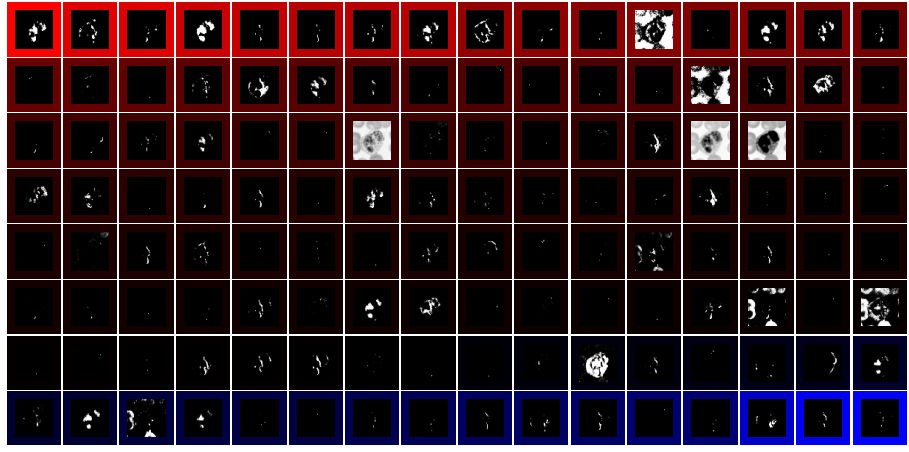

In [490]:
#Plot of all channels

mpl.rcParams['axes.linewidth'] = 8
sample=img

idx=np.argsort(relevance[0])
idx=np.flip(idx)
rel=[relevance[0,i] for i in idx]

height=8
width=16

plt.figure("visualise", (width,height))
out,feat_map=model(agent.make_seed(sample), steps=64,fire_rate=0.5)
feature_map=feat_map.detach()
sig=torch.nn.Sigmoid()
feature_map_sig=sig(feature_map-7)  #sigmoid is used to put values in a visible range, changing this function shows more or less of the features
feature_map=torch.cat((feature_map[:,:,:,:3],feature_map_sig[:,:,:,3:]),axis=3).cpu()
for i in range(height):
    for j in range(width):
        channel=width*i+j
        ax= plt.subplot(height,width,channel+1)
        r=relevance[0,idx[channel]]
        if r>0:
            ax.spines['bottom'].set_color((r,0,0))
            ax.spines['top'].set_color((r,0,0))
            ax.spines['left'].set_color((r,0,0))
            ax.spines['right'].set_color((r,0,0))
        else:
            ax.spines['bottom'].set_color((0,0,-r))
            ax.spines['top'].set_color((0,0,-r))
            ax.spines['left'].set_color((0,0,-r))
            ax.spines['right'].set_color((0,0,-r))
        plt.xticks([])
        plt.yticks([])
        plt.gray()
        plt.imshow(feature_map[0,:,:,idx[channel]])

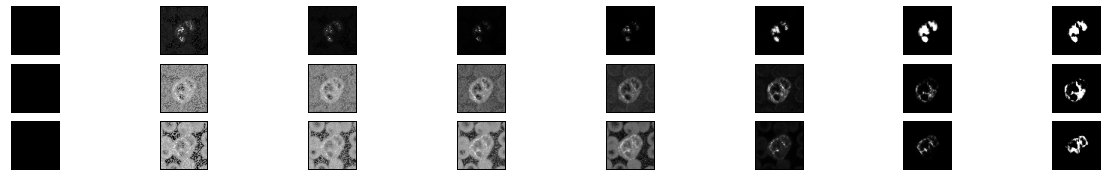

In [495]:
#Plot of activations over time

channels=[3,20,87]
nplots=8
mpl.rcParams['axes.linewidth'] = 1
plt.figure("visualise", (20,3))
for j in range(3):
    channel=channels[j]
    for i in range(nplots):
        steps=2**(i-1)#8*(1+i)
        if i ==0:
            steps=0
        out,feat_map=model(agent.make_seed(sample), steps=steps,fire_rate=0.5)
        feature_map=feat_map.detach()
        sig=torch.nn.Sigmoid()
        feature_map_sig=sig(feature_map-5)
        feature_map=torch.cat((feature_map[:,:,:,:3],feature_map_sig[:,:,:,3:]),axis=3).cpu()

        plt.subplot(3,nplots,j*nplots+i+1)
        plt.subplots_adjust(wspace=1)
        plt.xticks([])
        plt.yticks([])
        plt.gray()
        plt.imshow(feature_map[0,:,:,idx[channel]])
plt.savefig("channel_activations_BAS.svg")

In [ ]:
composite = z.EpsilonPlus()
img=get_sample(12,imgs_path=imgs_path) #0:2, 1:1, 2(12):0, 3:11, 4(10):9, 5(6):7, 6(9):0, 7:9, 
#8(5):4, 9(3):9, 10:7, 11:8, 12:4, 13:0
x=agent.make_seed(img)
input = model1(x)
with Gradient(model2, composite) as attributor:
    output, relevance = attributor(input, torch.eye(13)[[4]])
relevance=(relevance-relevance.min())/(relevance.max()-relevance.min())
relevance=2*relevance-1
relevance=relevance.numpy()

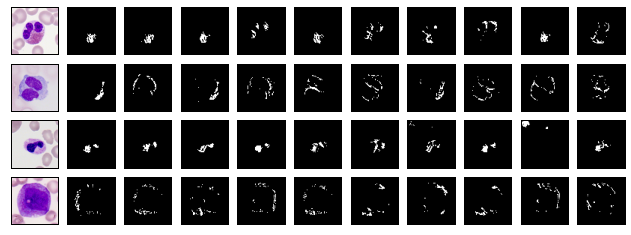

In [20]:
#Plot of highest relevance channels for 4 example images

height=4
width=11
plt.figure("visualise", (width,height))
samples=[1,7,10,12]
preds=[1,9,7,4]

for i in range(height):
    img=get_sample(samples[i],imgs_path=imgs_path)
    x=agent.make_seed(img)
    input = model1(x)
    with Gradient(model2, composite) as attributor:
        output, relevance = attributor(input, torch.eye(13)[[preds[i]]])
    relevance=(relevance-relevance.min())/(relevance.max()-relevance.min())
    relevance=2*relevance-1
    relevance=relevance.numpy()
    sample=img
    idx=np.argsort(relevance[0])
    idx=np.flip(idx)
    rel=[relevance[0,i] for i in idx]

    out,feat_map=model(agent.make_seed(sample), steps=64,fire_rate=0.5)
    feature_map=feat_map.detach()
    sig=torch.nn.Sigmoid()
    agg_mask=torch.zeros([64,64])
    for j in range(width):
        channel=width*i+j
        ax= plt.subplot(height,width,channel+1)
        r=relevance[0,idx[channel]]
        plt.xticks([])
        plt.yticks([])
        plt.gray()
        if j ==0:
            plt.imshow(Image.open(imgs_path[samples[i]]))
        else:
            map=feature_map[0,:,:,idx[j-1]]
            mask=map>torch.quantile(map,0.98)
            plt.imshow(mask)
            plt.savefig("lrp_activations\\thq98.svg")